<a href="https://colab.research.google.com/github/elka97/MachineLearningInBusiness/blob/main/homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [6]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [15]:
DATA_PATH = "/gdrive/My Drive/Ml_In_Business/lection2_materials/"
DATA_PATH

'/gdrive/My Drive/Ml_In_Business/lection2_materials/'

Наши новости

In [16]:
news = pd.read_csv(f"{DATA_PATH}articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [18]:
users = pd.read_csv(f"{DATA_PATH}users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### 1. Получаем векторные представления новостей

In [19]:
 pip install pymorphy2

     |████████████████████████████████| 55 kB 3.7 MB/s 
     |████████████████████████████████| 8.2 MB 45.2 MB/s 


In [20]:
!pip install razdel

In [21]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [22]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [23]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

morph = pymorphy2.MorphAnalyzer()
morph

151


In [25]:
with open(f"{DATA_PATH}stopwords_ru.txt") as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [27]:
def clean_text(text):
    '''
    очистка текста    
    на выходе очищеный текст    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [28]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Possible nested set at position 39
  del sys.path[0]


CPU times: user 24.6 s, sys: 1.26 s, total: 25.8 s
Wall time: 25.9 s


In [29]:
news['title'] 

0        заместитель председателяnправительства рфnсерг...
1        матч  финала кубка россии по футболу был приос...
2        форвард авангарда томаш заборский прокомментир...
3        главный тренер кубани юрий красножан прокоммен...
4        решением попечительского совета владивостокско...
                               ...                        
26995    ученые токийского университета морских наук и ...
26996    главой кафедры отечественной истории xx века и...
26997    американские ученые уточнили возраст расположе...
26998    за последние  лет тропический углеродный цикл ...
26999    у живших примерно  тыс лет назад на территории...
Name: title, Length: 27000, dtype: object

In [30]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 20s, sys: 755 ms, total: 4min 21s
Wall time: 4min 21s


А теперь в 3 строчки обучим нашу модель

In [31]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, примерно, тыс, назад, территория, совре...
Name: title, Length: 27000, dtype: object

In [32]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [ ]:
# texts

In [38]:
common_dictionary[10]

'ватутин'

In [ ]:
# common_corpus

Запускаем обучение

In [36]:
from gensim.models import LdaModel

In [37]:
LdaModel?

In [40]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 50.6 s, sys: 23.9 s, total: 1min 14s
Wall time: 47.5 s


In [43]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath(f"{DATA_PATH}model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [48]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(3, 0.5578233), (10, 0.07100323), (11, 0.19065881), (24, 0.16002685)]

In [52]:
x=lda.show_topics(num_topics=25, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Below Code Prints Only Words 
for topic, words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: млрд рубль банк рынок цена рост руб
topic_1: обнаружить газета агентство проверка задержать ru форум
topic_2: автор вода остров nn ген солнце телескоп
topic_3: налог офицер физика годовой железный автор спрос
topic_4: ракета луна китай миссия рак китайский nn
topic_5: космический поверхность планета космос мкс астероид астронавт
topic_6: всё топливо выше скорость земля способ снизиться
topic_7: украина газ украинский киев конкурс белоруссия мвд
topic_8: земля полёт чиновник полицейский высота восток обеспечивать
topic_9: животное продукция ступень оборудование кость птица биолог
topic_10: исследование научный nn турист фонд риск первый
topic_11: всё население очень журнал большой жизнь россия
topic_12: статья санкция данные размер млн документ стоимость
topic_13: россия российский путин рф доход правительство проект
topic_14: система эксперт проект новый спутник россия станция
topic_15: исследователь гражданин nn выяснить писать учёный русский
topic_16: эксперимент фонд дональ

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [53]:
#text = news['title'].iloc[0]
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [54]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.237299,0.000000,0.0,0.039998,0.028494,0.0,0.0,0.0,0.0,0.654971,0.000000,0.0,0.0,0.0,0.032516
1,4896,0.000000,0.117264,0.0,0.000000,0.0,0.0,0.000000,0.0,0.058657,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.646591,0.0,0.0,0.0,0.157000
2,4897,0.000000,0.000000,0.0,0.557849,0.0,0.0,0.000000,0.0,0.000000,0.0,0.071010,0.190625,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.160028
3,4898,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.029897,0.0,0.000000,0.0,0.082204,0.877423,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
4,4899,0.534574,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.090629,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.351013,0.000000,0.0,0.0,0.0,0.000000


### Следующий шаг - векторные представления пользователей

In [55]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [56]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [57]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.0415783 , 0.        ,
       0.09773951, 0.        , 0.09540377, 0.        , 0.01319944,
       0.03953821, 0.10307562, 0.        , 0.26261637, 0.        ,
       0.14385106, 0.01323838, 0.11857128, 0.04690615, 0.        ,
       0.        , 0.        , 0.01869044, 0.        , 0.        ])

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [213]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [351]:
def model_by_user_embedding_mode(user_embeddings_df:pd.DataFrame, y: pd.Series, embedding_calc_mode:str):

  print(user_embeddings_df.head(3))

  _X = pd.merge(user_embeddings_df, y, 'left')
  # print("X= ", _X.head(3))

  #разделим данные на train/test
  _X_train, _X_test, _y_train, _y_test = train_test_split(_X[['topic_{}'.format(i) for i in range(25)]], 
                                                      X['churn'], random_state=0)
  print(_X_train.shape, X_test.shape)

  logreg = LogisticRegression()
  #обучим 
  logreg.fit(_X_train, _y_train)

  #наши прогнозы для тестовой выборки
  _preds = logreg.predict_proba(_X_test)[:, 1]
  # print("predictions: ", _preds[:10])

  _precision, _recall, _thresholds = precision_recall_curve(_y_test, _preds)
  _fscore = (2 * _precision * _recall) / (_precision + _recall)
  
  # locate the index of the largest f score 
  ix = np.argmax(_fscore)

  _rocauc_score = roc_auc_score(_y_test, _preds)

  print(f"Best Threshold={_thresholds[ix]}, F-Score={_fscore[ix]}, Precision={_precision[ix]}, Recall={_recall[ix]}, RocAucScore={_rocauc_score}") 
  
  #мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
  font = {'size' : 15}
  plt.rc('font', **font)

  cnf_matrix = confusion_matrix(_y_test, _preds > _thresholds[ix])
  plt.figure(figsize=(10, 8))
  plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'], title=f"Confusion matrix {embedding_calc_mode}")
  plt.savefig(f"{DATA_PATH}conf_matrix_{embedding_calc_mode}.png")
  plt.show()

  return _precision[ix], _recall[ix], _thresholds[ix], _fscore[ix], _rocauc_score

In [352]:
target = pd.read_csv(f"{DATA_PATH}users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [353]:
def get_user_embedding_mean(_user_articles_list):
    _user_articles_list = eval(_user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in _user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [354]:
user_embeddings_mean = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_mean(x), 1)])
user_embeddings_mean.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_mean['uid'] = users['uid'].values
user_embeddings_mean = user_embeddings_mean[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.045367,0.000000,0.071648,0.005236,0.051460,0.000000,0.069855,0.017844,0.016139,0.076734,0.034613,0.038452,0.187609,0.036009,0.088264,0.023196,0.103112,0.074291,0.000000,0.005436,0.016875,0.021927,0.000000,0.000000
1,u108690,0.019377,0.070715,0.012527,0.001913,0.007859,0.009074,0.032131,0.097525,0.024836,0.010104,0.038218,0.123796,0.044139,0.116728,0.018826,0.023168,0.000000,0.069062,0.029278,0.051626,0.006943,0.080587,0.060088,0.034249,0.002423
2,u108339,0.022887,0.042836,0.014330,0.000000,0.064582,0.006487,0.019862,0.027327,0.020104,0.008165,0.062921,0.029359,0.029402,0.121820,0.015476,0.029166,0.004410,0.165325,0.025290,0.066839,0.025668,0.026121,0.147091,0.009689,0.000000


       uid   topic_0   topic_1  ...  topic_22  topic_23  topic_24
0  u105138  0.000000  0.045367  ...  0.021927  0.000000  0.000000
1  u108690  0.019377  0.070715  ...  0.060088  0.034249  0.002423
2  u108339  0.022887  0.042836  ...  0.147091  0.009689  0.000000

[3 rows x 26 columns]
(6000, 25) (2000, 25)
Best Threshold=0.2783930512103812, F-Score=0.66, Precision=0.6470588235294118, Recall=0.673469387755102, RocAucScore=0.9438525495668352
Confusion matrix, without normalization
[[1665   90]
 [  81  164]]


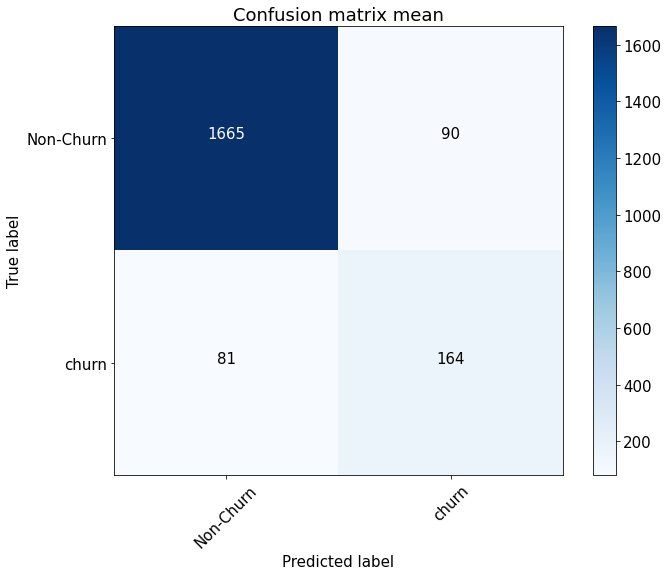

In [355]:
mean_precision, mean_recall, mean_thresholds, mean_fscore, mean_roc_auc_score = model_by_user_embedding_mode(user_embeddings_mean, y=target, embedding_calc_mode="mean")

**2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)**

In [332]:
def get_user_embedding_median(_user_articles_list):
    _user_articles_list = eval(_user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in _user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [356]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.000000,0.000000,0.01402,0.0,0.0,0.000000,0.043629,0.000000,0.006600,0.029798,0.000000,0.000000,0.182772,0.000000,0.077999,0.0,0.059286,0.044517,0.000000,0.00000,0.0,0.000000,0.000000,0.0
1,u108690,0.0,0.030066,0.006184,0.00000,0.0,0.0,0.023472,0.059037,0.005173,0.000000,0.035648,0.122761,0.033341,0.114743,0.005921,0.000000,0.0,0.032134,0.028957,0.026125,0.00000,0.0,0.021802,0.005895,0.0
2,u108339,0.0,0.045006,0.011415,0.00000,0.0,0.0,0.018228,0.006624,0.006258,0.007775,0.028809,0.022162,0.027360,0.094671,0.011999,0.000000,0.0,0.131954,0.006342,0.039258,0.00837,0.0,0.121877,0.000000,0.0


       uid  topic_0   topic_1   topic_2  ...  topic_21  topic_22  topic_23  topic_24
0  u105138      0.0  0.000000  0.000000  ...       0.0  0.000000  0.000000       0.0
1  u108690      0.0  0.030066  0.006184  ...       0.0  0.021802  0.005895       0.0
2  u108339      0.0  0.045006  0.011415  ...       0.0  0.121877  0.000000       0.0

[3 rows x 26 columns]
(6000, 25) (2000, 25)
Best Threshold=0.2693832022750445, F-Score=0.7248062015503877, Precision=0.6900369003690037, Recall=0.763265306122449, RocAucScore=0.9599930228501657
Confusion matrix, without normalization
[[1671   84]
 [  59  186]]


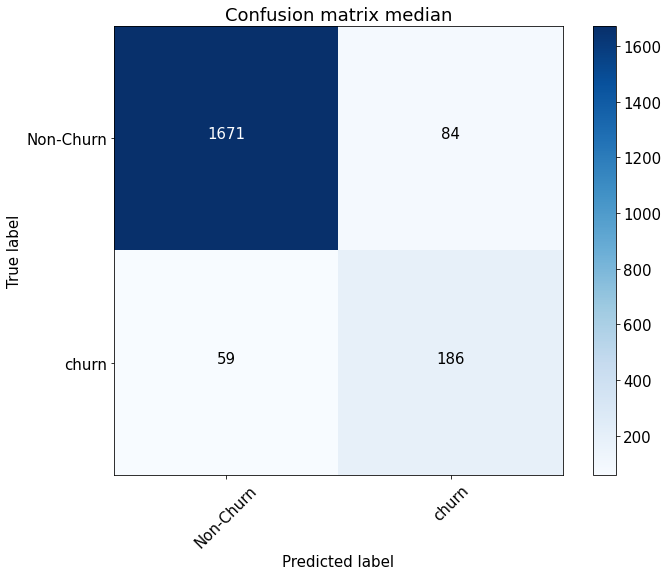

In [357]:
median_precision, median_recall, median_thresholds, median_fscore, median_roc_auc_score = model_by_user_embedding_mode(user_embeddings_median, y=target, embedding_calc_mode="median")

**3. Повторить п.2, но используя уже не медиану, а max**

In [369]:
def get_user_embedding_max(_user_articles_list):
    lst = eval(_user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in lst])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [370]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.207179,0.000000,0.360269,0.031413,0.211019,0.000000,0.236471,0.107063,0.053119,0.361270,0.104604,0.215855,0.460260,0.134868,0.229732,0.125940,0.271644,0.269741,0.000000,0.032617,0.090489,0.112872,0.000000,0.000000
1,u108690,0.068936,0.248399,0.032714,0.011480,0.033132,0.028430,0.087869,0.250043,0.127371,0.060625,0.093519,0.277181,0.144169,0.184519,0.063345,0.071308,0.000000,0.199795,0.072407,0.184679,0.022671,0.385530,0.253364,0.143083,0.014539
2,u108339,0.116450,0.083926,0.047217,0.000000,0.241770,0.025685,0.051911,0.112615,0.072095,0.016828,0.166313,0.080325,0.084664,0.281779,0.038144,0.174998,0.015734,0.383099,0.088833,0.183332,0.094834,0.135978,0.291995,0.032481,0.000000


       uid   topic_0   topic_1  ...  topic_22  topic_23  topic_24
0  u105138  0.000000  0.207179  ...  0.112872  0.000000  0.000000
1  u108690  0.068936  0.248399  ...  0.253364  0.143083  0.014539
2  u108339  0.116450  0.083926  ...  0.291995  0.032481  0.000000

[3 rows x 26 columns]
(6000, 25) (2000, 25)
Best Threshold=0.3702635494349564, F-Score=0.7845528455284553, Precision=0.7813765182186235, Recall=0.7877551020408163, RocAucScore=0.969595906738764
Confusion matrix, without normalization
[[1701   54]
 [  53  192]]


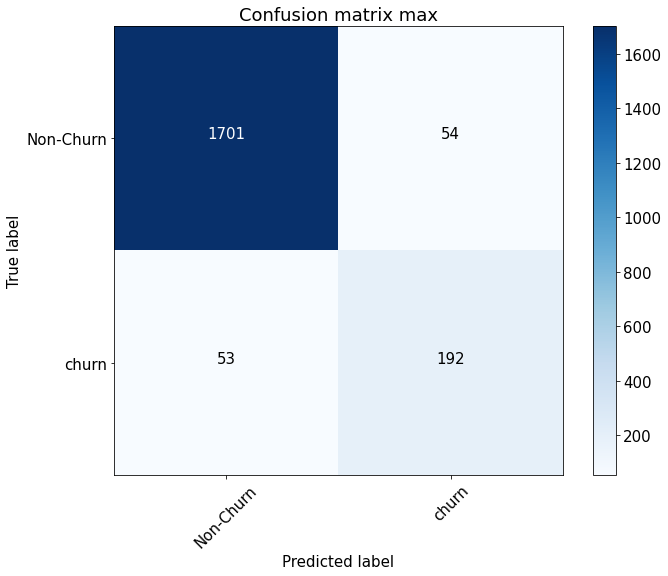

In [371]:
max_precision, max_recall, max_thresholds, max_fscore, max_roc_auc_score = model_by_user_embedding_mode(user_embeddings_max, y=target, embedding_calc_mode="max")

**5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score**

In [365]:
results = pd.DataFrame(data=[[mean_precision, mean_recall, mean_thresholds, mean_fscore, mean_roc_auc_score], 
                             [median_precision, median_recall, median_thresholds, median_fscore, median_roc_auc_score],
                             [max_precision, max_recall, max_thresholds, max_fscore, max_roc_auc_score]], 
                       columns=["precision", "recall", "thresholds", "fscore", "roc_auc_score"],
                       index=["mean","median", "max"] )
results

,precision,recall,thresholds,fscore,roc_auc_score
mean,0.647059,0.673469,0.278393,0.660000,0.943853
median,0.690037,0.763265,0.269383,0.724806,0.959993
max,0.781377,0.787755,0.370264,0.784553,0.969596


**6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных**

Лучший результат показала функция по мах. т.е. лучше всего пользователя характеризует вектор с ярко выраженными топиками? 
Неоднозначно... при разных запусках и рандом_стате получлись результаты лучше с медианой?